In [3]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# Define dataset paths
DATA_DIR = "datasets_img"  # Main directory for organized data
LSBGs_DIR = "original\\1_LSBGs"  # Positive class folder
NEG_DIR = "original\\0_neg_typ_2"  # Negative class folder
MODEL_DIR = "models"

In [4]:

def plot_sample_images(folder_path, title, num_samples=5):
    """
    Plots a specified number of sample images from a given folder.
    
    Args:
        folder_path (str): Path to the folder containing images.
        num_samples (int): Number of images to randomly sample and display.
    """
    if not os.path.exists(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
        return

    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"No image files found in '{folder_path}'.")
        return

    # Randomly select `num_samples` images (or all if fewer exist)
    selected_files = random.sample(image_files, min(len(image_files), num_samples))

    # Plot images
    fig, axes = plt.subplots(1, len(selected_files), figsize=(12, 3))
    fig.suptitle(title, fontsize=16)

    if len(selected_files) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only 1 image

    for ax, img_name in zip(axes, selected_files):
        img_path = os.path.join(folder_path, img_name)
        image = Image.open(img_path)

        # Convert grayscale images to RGB (for consistency)
        image = image.convert("RGB")

        ax.imshow(image)
        ax.axis("off")
        ax.set_title(img_name[:10] + "...")  # Show truncated filename

    plt.tight_layout()
    plt.show()


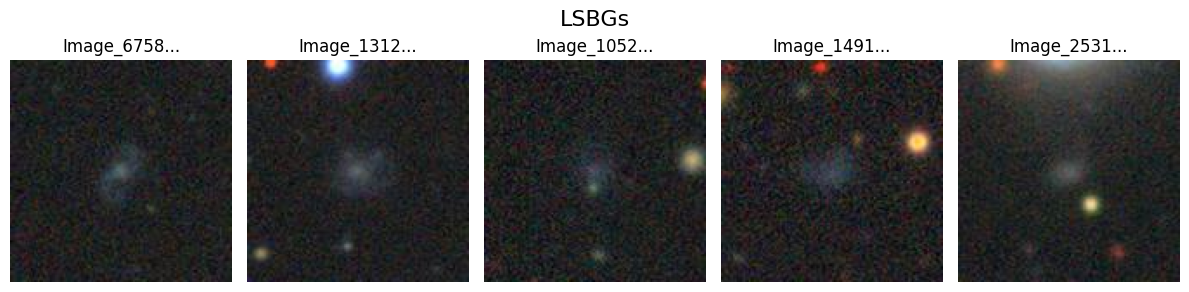

In [5]:
plot_sample_images(os.path.join(DATA_DIR, LSBGs_DIR), 'LSBGs', 5)

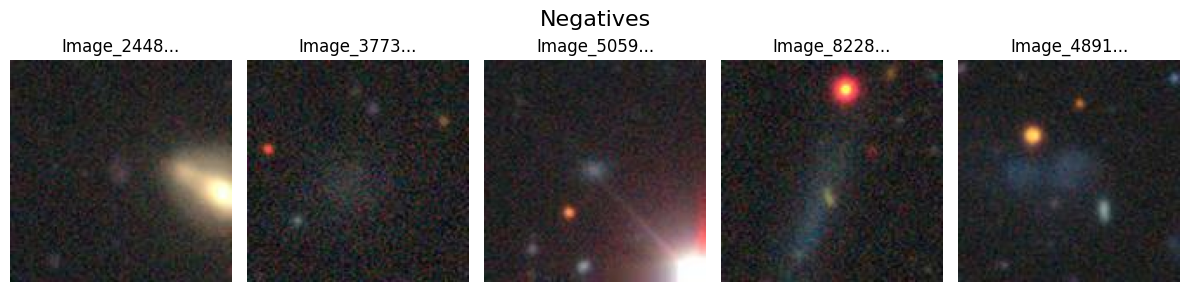

In [6]:
plot_sample_images(os.path.join(DATA_DIR, NEG_DIR), 'Negatives', 5)

In [ ]:
import os
import shutil
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define splits (Train: 80%, Val: 10%, Test: 10%)
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# Create organized dataset structure if not exists
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(DATA_DIR, split, "1_LSBGs"), exist_ok=True)
    os.makedirs(os.path.join(DATA_DIR, split, "0_neg_typ_2"), exist_ok=True)

def split_and_copy_images(class_dir, class_name):
    """
    Splits images into train, val, and test folders while preserving binary classification labels.
    """
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_files)  # Shuffle before splitting

    # Split sizes
    train_size = int(len(image_files) * TRAIN_RATIO)
    val_size = int(len(image_files) * VAL_RATIO)
    test_size = len(image_files) - train_size - val_size  # Remaining for test

    # Assign images to each set
    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size + val_size]
    test_files = image_files[train_size + val_size:]

    # Copy files to new dataset structure
    for file, split in zip([train_files, val_files, test_files], ["train", "val", "test"]):
        for img in file:
            src = os.path.join(class_dir, img)
            dst = os.path.join(DATA_DIR, split, class_name, img)
            shutil.copy(src, dst)

    print(f"Processed {class_name}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

# Split and copy images
split_and_copy_images(os.path.join(DATA_DIR, LSBGs_DIR), "1_LSBGs")
split_and_copy_images(os.path.join(DATA_DIR, NEG_DIR), "0_neg_typ_2")

# Define transformations (resizing, normalization for pre-trained models)
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize for ResNet, EfficientNet, etc.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "val"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "test"), transform=transform)

# Create DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Train: {len(train_dataset)} images")
print(f"Val: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")

# Print class mapping (should be {'LSBGs': 0, 'neg_typ_2': 1})
print("Class Mapping:", train_dataset.class_to_idx)


Processed 1_LSBGs: Train=7428, Val=928, Test=930
Processed 0_neg_typ_2: Train=6952, Val=869, Test=870
Train: 14380 images
Val: 1797 images
Test: 1800 images
Class Mapping: {'0_neg_typ_2': 0, '1_LSBGs': 1}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

SAVE_DIR = "models"

# 🔹 Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Function to evaluate model and plot confusion matrix
def evaluate_model(model, dataloader):
    y_true = []
    y_pred = []

    # Disable gradients for inference
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Store true labels and predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_names = ["0_neg_typ_2", "1_LSBGs"]

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# 🔹 Function to Load Pretrained Model and Modify it for Classification
def get_model(model_name):
    """
    Loads a pretrained model and modifies it for binary classification.
    
    Args:
        model_name (str): Name of the model architecture to load.

    Returns:
        model (torch.nn.Module): Modified model.
    """
    if model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    elif model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    elif model_name == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    elif model_name == "vgg19":
        model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # 🔹 Modify First Convolution Layer for ResNet-based models
    if "resnet" in model_name:
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    # 🔹 Modify Fully Connected (FC) Layer for Binary Classification
    if "vgg" in model_name:
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, 2)
    else:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)

    return model.to(device)


# 🔹 Training and Validation Logic
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, model_name):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.model_name = model_name
        self.best_val_loss = float("inf")
        
        # ✅ Fixed List Initialization
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_model(self, num_epochs, save_dir):
        """
        Trains the model and evaluates it.
        
        Args:
            num_epochs (int): Number of training epochs.
            save_dir (str): Directory to save the best model.
        """
        os.makedirs(save_dir, exist_ok=True)

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Training Phase
            self.model.train()
            running_loss, correct, total = 0.0, 0, 0

            # ✅ tqdm Progress Bar for Training
            train_progress = tqdm(self.train_loader, desc=f"Training Epoch {epoch+1}", leave=False)
            for images, labels in train_progress:
                images, labels = images.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                # ✅ Update tqdm bar with current loss
                train_progress.set_postfix(loss=loss.item(), acc=100 * correct / total)

            train_loss = running_loss / len(self.train_loader)
            train_acc = 100 * correct / total
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

            # Validation Phase
            self.model.eval()
            val_loss, correct, total = 0.0, 0, 0

            # ✅ tqdm Progress Bar for Validation
            val_progress = tqdm(self.val_loader, desc=f"Validating Epoch {epoch+1}", leave=False)
            with torch.no_grad():
                for images, labels in val_progress:
                    images, labels = images.to(device), labels.to(device)
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    # ✅ Update tqdm bar with current loss
                    val_progress.set_postfix(loss=loss.item(), acc=100 * correct / total)

            val_loss = val_loss / len(self.val_loader)
            val_acc = 100 * correct / total
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

            # Save Best Model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                model_path = os.path.join(save_dir, f"{self.model_name}_best.pth")
                torch.save(self.model.state_dict(), model_path)
                print(f"✅ Best model saved: {model_path}")

        # Plot training curves
        self.plot_training_curves()

    def plot_training_curves(self):
        """
        Plots loss and accuracy curves.
        """
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Train Loss")
        plt.plot(epochs, self.val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{self.model_name}: Training & Validation Loss")
        plt.legend()

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label="Train Accuracy")
        plt.plot(epochs, self.val_accuracies, label="Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"{self.model_name}: Training & Validation Accuracy")
        plt.legend()
        plt.show()



Using device: cuda


# vgg16


Epoch 1/5


Train Loss: 0.3652, Train Accuracy: 83.87%


Val Loss: 0.2858, Val Accuracy: 87.53%
✅ Best model saved: models\vgg16_best.pth

Epoch 2/5


Train Loss: 0.2387, Train Accuracy: 90.44%


Val Loss: 0.2564, Val Accuracy: 88.54%
✅ Best model saved: models\vgg16_best.pth

Epoch 3/5


Train Loss: 0.2049, Train Accuracy: 91.97%


Val Loss: 0.2465, Val Accuracy: 89.48%
✅ Best model saved: models\vgg16_best.pth

Epoch 4/5


Train Loss: 0.1775, Train Accuracy: 92.97%


Val Loss: 0.2388, Val Accuracy: 89.82%
✅ Best model saved: models\vgg16_best.pth

Epoch 5/5


Train Loss: 0.1490, Train Accuracy: 94.40%


Val Loss: 0.2603, Val Accuracy: 89.59%


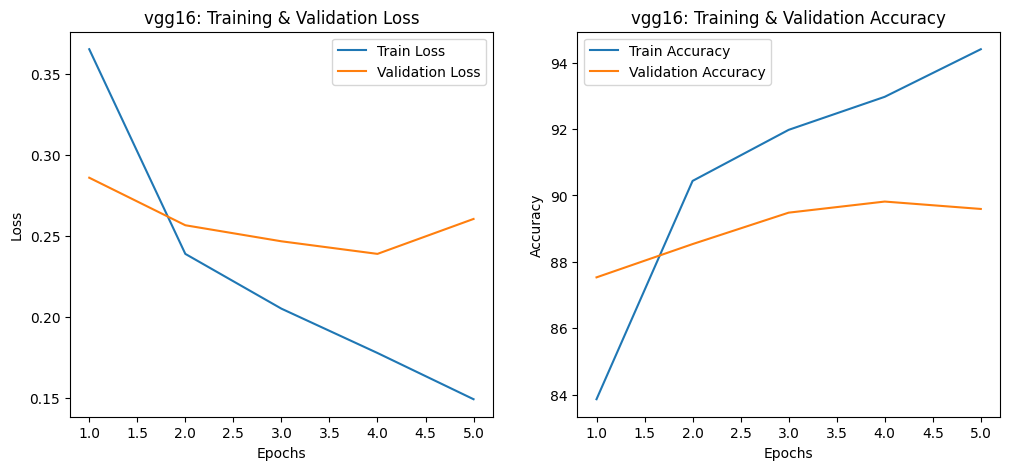

In [22]:
# 🔹 Define Training Parameters
#MODEL_NAME = "vgg16"  # Change to "resnet50", "resnet18", "efficientnet_b0", "vgg16", or "vgg19"
NUM_EPOCHS = 5
LEARNING_RATE = 1e-5

#NUM_CLASSES = 2  # Binary classification (LSBG vs. non-LSBG)

# 🔹 Load Selected Model
vgg16_model = get_model("vgg16")

# 🔹 Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_model.parameters(), lr=LEARNING_RATE)

# 🔹 Initialize Trainer
trainer = ModelTrainer(vgg16_model, train_loader, val_loader, criterion, optimizer, "vgg16")

# 🔹 Train Model
trainer.train_model(NUM_EPOCHS, SAVE_DIR)

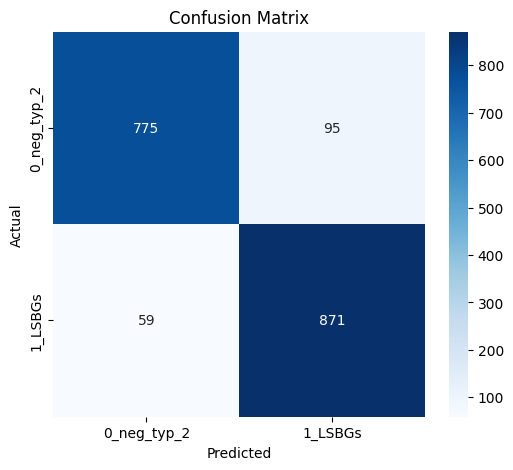

Classification Report:
               precision    recall  f1-score   support

 0_neg_typ_2       0.93      0.89      0.91       870
     1_LSBGs       0.90      0.94      0.92       930

    accuracy                           0.91      1800
   macro avg       0.92      0.91      0.91      1800
weighted avg       0.91      0.91      0.91      1800



In [24]:
vgg16_model.load_state_dict(torch.load(os.path.join(SAVE_DIR, f"vgg16_best.pth")))
vgg16_model = vgg16_model.to(device)
vgg16_model.eval()
evaluate_model(vgg16_model, test_loader)

# resnet50

In [ ]:
# 🔹 Define Training Parameters
NUM_EPOCHS = 5
LEARNING_RATE = 1e-5

# 🔹 Load Selected Model
model_resnet50 = get_model("resnet50")

# 🔹 Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet50.parameters(), lr=LEARNING_RATE)

# 🔹 Initialize Trainer
trainer = ModelTrainer(model_resnet50, train_loader, val_loader, criterion, optimizer, "resnet50")

# 🔹 Train Model
trainer.train_model(NUM_EPOCHS, SAVE_DIR)


Epoch 1/5


Train Loss: 0.5074, Train Accuracy: 76.33%


Val Loss: 0.3482, Val Accuracy: 84.31%
✅ Best model saved: models\resnet50_best.pth

Epoch 2/5


Train Loss: 0.3044, Train Accuracy: 87.55%


Val Loss: 0.2945, Val Accuracy: 87.09%
✅ Best model saved: models\resnet50_best.pth

Epoch 3/5


Training Epoch 3:   5%|▍         | 11/225 [00:18<01:57,  1.82it/s, acc=89.2, loss=0.213]

In [ ]:
model_resnet50.load_state_dict(torch.load(os.path.join(SAVE_DIR, f"resnet50_best.pth")))
model_resnet50 = model_resnet50.to(device)
model_resnet50.eval()
evaluate_model(model_resnet50, test_loader)

# efficientnet_b0

In [ ]:
# 🔹 Define Training Parameters
NUM_EPOCHS = 5
LEARNING_RATE = 1e-5

# 🔹 Load Selected Model
model_efficientnet_b0 = get_model("efficientnet_b0")

# 🔹 Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet_b0.parameters(), lr=LEARNING_RATE)

# 🔹 Initialize Trainer
trainer = ModelTrainer(model_efficientnet_b0, train_loader, val_loader, criterion, optimizer, "efficientnet_b0")

# 🔹 Train Model
trainer.train_model(NUM_EPOCHS, SAVE_DIR)

In [ ]:
model_efficientnet_b0.load_state_dict(torch.load(os.path.join(SAVE_DIR, f"efficientnet_b0_best.pth")))
model_efficientnet_b0 = model_efficientnet_b0.to(device)
model_efficientnet_b0.eval()
evaluate_model(model_efficientnet_b0, test_loader)